### import all modules

<p>Here we import all necessary modules for the process</p>

In [1]:
# Custom helper functions
# ========================================
from finance import getAllData, getMainDataset
from collect_news import getArticleHeadlines
# =========================================

import matplotlib.pyplot as plt
import datetime, math
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

### Set all Initial variables
<p>All initial variables to work with are set here.</p> 

<p>
    <ul>
        <li>days_in_advanced: How many days in the future.</li>
        <li>download_all_tickers_data: (Bool) Download the latest datasets from the tickers symbols in the tickers list</li>
        <li>collect_current_headlines: Collect latest headlines.</li>
        <li>single_ticker: Choose a single ticker with which all the analysis is going to be wored. in this case the S&P500 index.</li>
        <li>tickers: A list of tickers from which all the dataset to download for testing and building models.</li>
        <li>start: (datetime) A starting date for all the time series.</li>
        <li>end: (datetime) An ending date for all time series</li>
    </ul>
    <br />
    All time series data are going to consist of all the sales between the start date and end date and from these dataframes were are going to try and predict the <i>days_in_advanced</i> number of days future prices.
</p>

In [2]:
# ================================
days_in_advanced = 5
download_all_tickers_data = False
collect_current_headlines = False
single_ticker = '^GSPC'
tickers = ['AAPL', 'B', 'F', 'FB', 'GOOGL', 'AMZN', 'AAL', 'TSLA', 'SBUX', 'MSFT', 'NFLX', 'PYPL', 'GE', 'EBAY', 'BAC', 'JPM', 'GS', 'CCE', 'INTC', 'IBM', '^GSPC']
start = datetime.datetime(2007, 1, 1)
end =  datetime.datetime(2017, 9, 15)
# =================================

### Define Train Test splits functions
<p>Here we define train test split functions to divide our dataset training set and testing set. The purpose of these functions is to test sequences rather than randomized dataframes inputs.</p>

In [3]:
def train_test(data, ratio=0.2):
	train_ratio = data.shape[0] - int(math.ceil(data.shape[0] * ratio))
	train = data.iloc[:train_ratio]
	test  = data.iloc[train_ratio:]
	return [train, test]	


def split_train_test(train, test, labels= [], features=[]):
	X_train = train[features]
	X_test = test[features] 
	y_train = train[labels]
	y_test = test[labels]
	return [X_test, y_test, X_train, y_train]


### Collect All data
<p>The <i>getAllData</i> function collect the most accurate data sets for both Headlines and Time series and it formats them for the purpose of this analysis. This can be used in case the mentioned datasets are not present in the local file system.</p>

In [4]:
# =========================================================================
# Collect all the data from the ticker list
# =========================================================================
getAllData(tickers, get_all=download_all_tickers_data, start=start, end=end)
# ==========================================================================

### The Datasets
<p>We get the datasets that we are going to be working with here.</p>
<p>The helper function merges both Headline datasets and the data time series together. This is the raw version of the collected datasets.</p>

In [5]:
data = getMainDataset(single_ticker=single_ticker, headlines=True, current_headlines=collect_current_headlines)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Headlines,compound,neg,neu,pos
Date,,,,,,,,,,,
2017-09-05,2470.350098,2471.969971,2446.550049,2457.850098,2457.850098,3490260000,"Trump Chooses Sessions, Longtime Foe of DACA, ...",-0.2732,0.143,0.729,0.128
2017-09-07,2468.060059,2468.620117,2460.290039,2465.100098,2465.100098,3353930000,"The Debt Ceiling: Why We Have It, and What Wou...",-0.8271,0.179,0.716,0.105
2017-09-11,2474.520020,2488.949951,2474.520020,2488.110107,2488.110107,0,Congress Rejects Trump Proposals to Cut Health...,-0.3818,0.171,0.742,0.087
2017-09-13,2493.889893,2498.370117,2492.139893,2498.370117,2498.370117,3368050000,Trump Administration Punishes Countries That R...,-0.9217,0.149,0.778,0.073
2017-09-15,2495.669922,2500.229980,2493.159912,2500.229980,2500.229980,4853170000,Judiciary Chairman Considers Subpoenas in Trum...,-0.0352,0.039,0.908,0.053


### Data Exploration.
<p>To start the process, we do some feature engineering to isolate the Financial time series for the S&P500</p>

In [6]:
times_series_cols =  ['Open', 'High','Low','Close','Adj Close','Volume']
time_series_df = data[times_series_cols]
time_series_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-05,2470.350098,2471.969971,2446.550049,2457.850098,2457.850098,3490260000
2017-09-07,2468.060059,2468.620117,2460.290039,2465.100098,2465.100098,3353930000
2017-09-11,2474.520020,2488.949951,2474.520020,2488.110107,2488.110107,0
2017-09-13,2493.889893,2498.370117,2492.139893,2498.370117,2498.370117,3368050000
2017-09-15,2495.669922,2500.229980,2493.159912,2500.229980,2500.229980,4853170000


In [7]:
time_series_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2678.000000,2678.000000,2678.000000,2678.000000,2678.000000,2.678000e+03
mean,1568.166190,1577.030953,1558.542252,1568.487766,1568.487766,4.007753e+09
std,433.685127,432.795079,434.617331,433.833274,433.833274,1.173332e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,0.000000e+00
25%,1251.734955,1260.124970,1239.932495,1252.367554,1252.367554,3.279425e+09
50%,1456.059998,1463.190002,1446.734985,1456.130005,1456.130005,3.761695e+09
75%,1983.052521,1989.645019,1974.220001,1983.980011,1983.980011,4.480975e+09
max,2495.669922,2500.229980,2493.159912,2500.229980,2500.229980,1.145623e+10


### Plot Density distribution

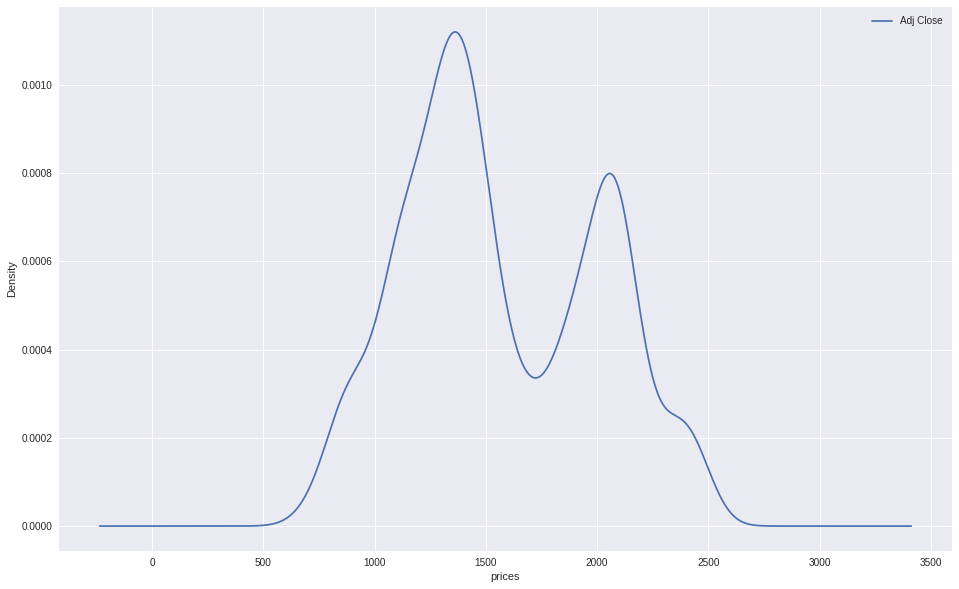

In [8]:
dp = time_series_df[['Adj Close']].plot(kind='kde', figsize=(16,10))
dp.set_xlabel('prices')

### Plot histogram

(array([   5.,    4.,    7.,   11.,   16.,   34.,   36.,   45.,   27.,
          13.,   24.,   20.,   53.,   72.,   76.,   53.,   67.,   63.,
          49.,   88.,   86.,  131.,   98.,   96.,  109.,   88.,   62.,
          79.,   54.,   25.,   16.,   26.,   30.,   42.,    5.,   19.,
          27.,   23.,   42.,   56.,   28.,   51.,   51.,   59.,   55.,
          89.,  132.,   67.,   39.,   43.,    9.,    7.,   29.,    9.,
          11.,   35.,   25.,   31.,   14.,   17.]),
 array([  676.530029  ,   706.92502818,   737.32002737,   767.71502655,
          798.11002573,   828.50502492,   858.9000241 ,   889.29502328,
          919.69002247,   950.08502165,   980.48002083,  1010.87502002,
         1041.2700192 ,  1071.66501838,  1102.06001757,  1132.45501675,
         1162.85001593,  1193.24501512,  1223.6400143 ,  1254.03501348,
         1284.43001267,  1314.82501185,  1345.22001103,  1375.61501022,
         1406.0100094 ,  1436.40500858,  1466.80000777,  1497.19500695,
         1527.5900

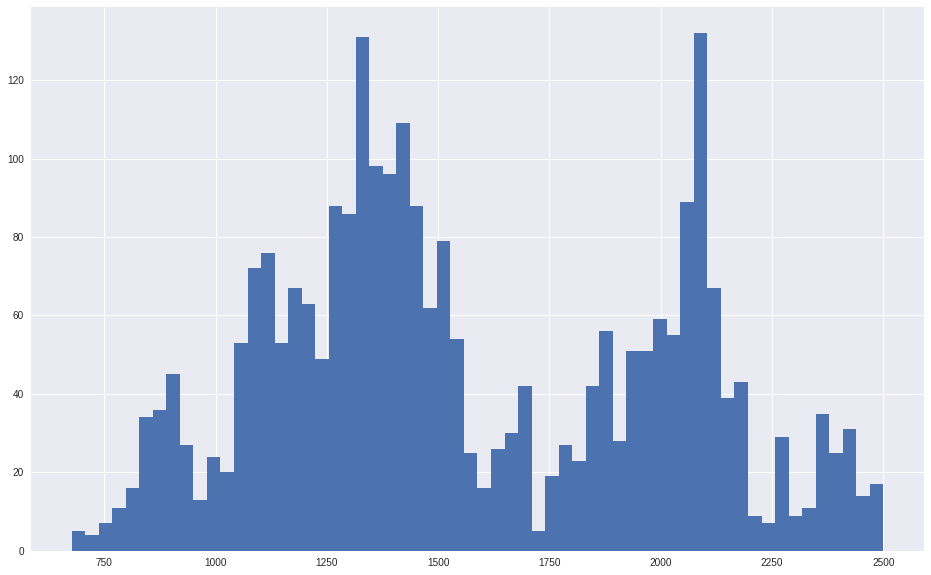

In [9]:
plt.figure(figsize=(16,10))
plt.hist(time_series_df['Adj Close'], 60)

### Boxplot
<p>Check if the stock dataset has outliers.</p>

/home/bwadmin/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


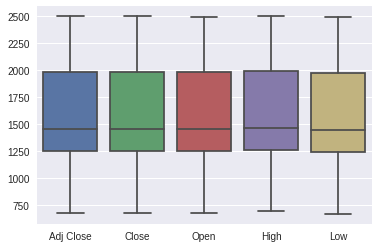

In [10]:
sns.boxplot(time_series_df[['Adj Close', 'Close', 'Open', 'High', 'Low']]) 

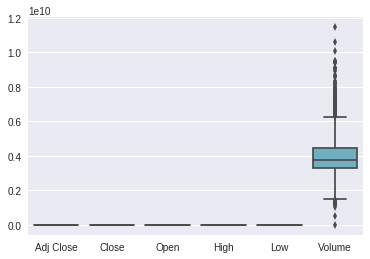

In [11]:
sns.boxplot(time_series_df[['Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume']]) 

### The dataset
<p>Here we plot the Open, High, Low, and Adj Close of the whole dataset.</p>

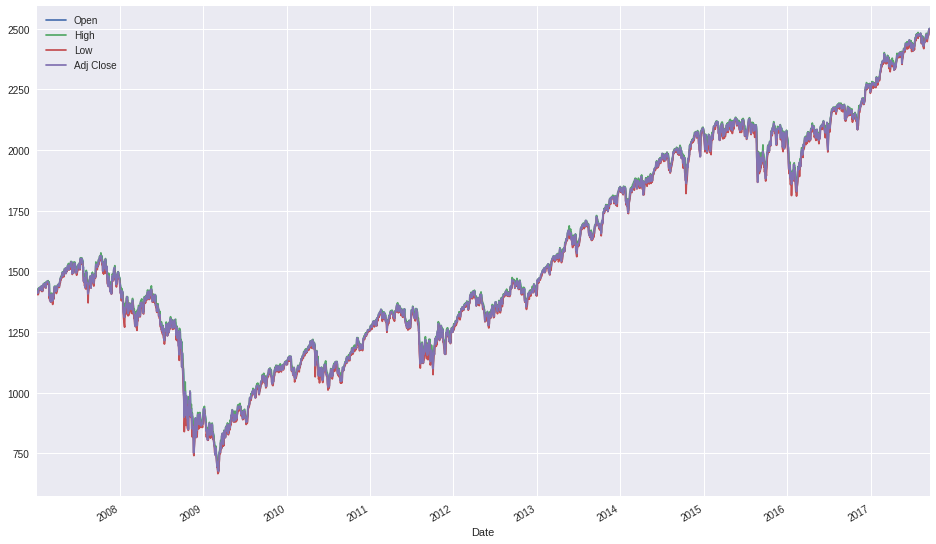

In [12]:
time_series_df[['Open', 'High', 'Low', 'Adj Close']].plot(figsize=(16,10))

### The value of the price over the years
<p>This is just the value of Adj Close price over the years. This is what we want to predict as future price.</p>

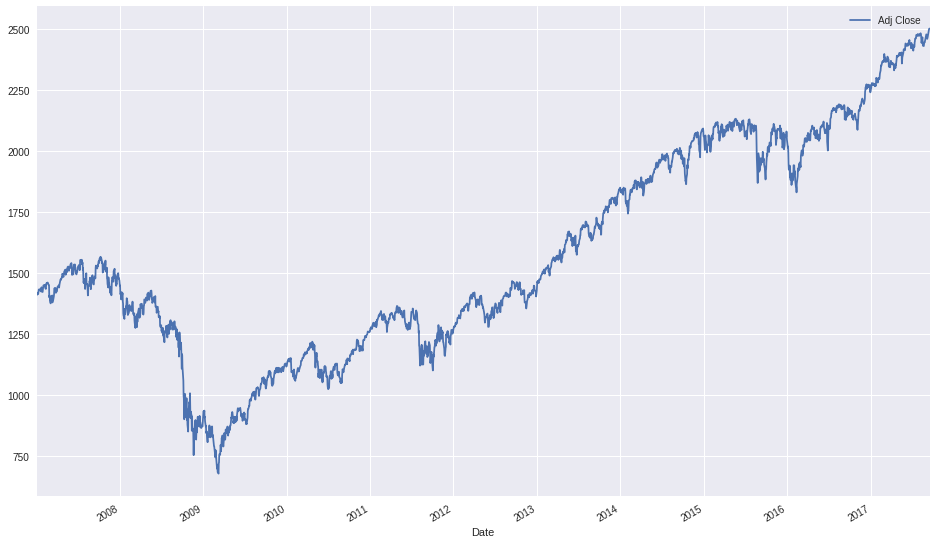

In [13]:
time_series_df[['Adj Close']].plot(figsize=(16,10))

### Graph of the year 2017
<p>Plotting the data will help to discover and explore the data better.</p>

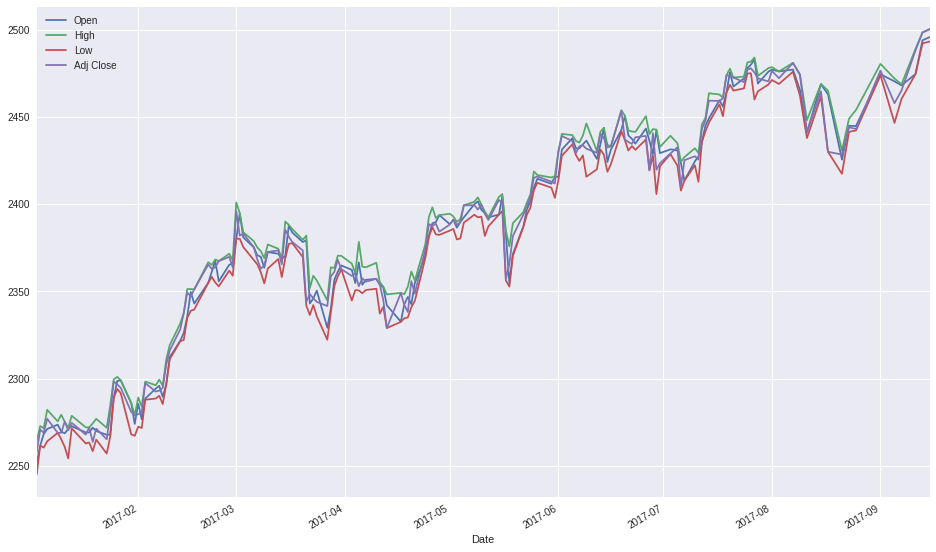

In [14]:
time_series_df[['Open', 'High', 'Low', 'Adj Close']].loc['2017-01-01':].plot(figsize=(16,10))

/home/bwadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bwadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/bwadmin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,Adj Close,predicted_stock_price,Volume,rolling_mean,upper_band,lower_band
Date,,,,,,
2017-08-17,2430.010010,2457.850098,1693.451188,2466.437012,2493.068491,2439.805532
2017-08-21,2428.370117,2465.100098,1679.163285,2465.464014,2496.081537,2434.846490
2017-08-23,2444.040039,2488.110107,1679.048005,2464.702515,2496.695373,2432.709657
2017-08-25,2443.050049,2498.370117,1671.127121,2463.898022,2497.259745,2430.536300
2017-09-01,2476.550049,2500.229980,1676.042656,2464.695020,2498.484868,2430.905171


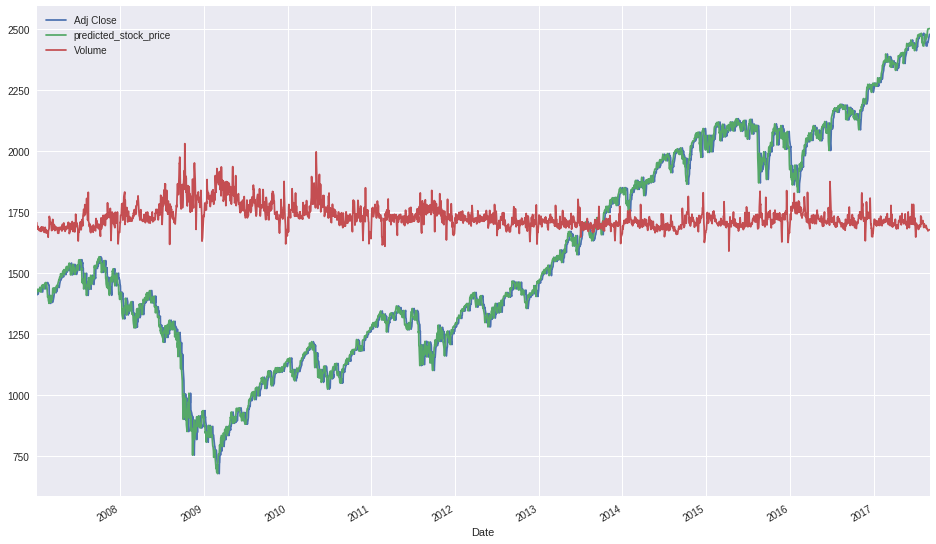

In [15]:
data = getMainDataset(single_ticker=single_ticker, headlines=True, current_headlines=collect_current_headlines)
# =============================================
# 				No headlines
# =============================================

data['predicted_stock_price'] = data['Adj Close'].shift(-days_in_advanced)
data = data[:-days_in_advanced]

chosen_cols = [
    'Adj Close', 
    'predicted_stock_price',
    'Volume'
]
data['Volume'] = data['Volume'] / (data['Adj Close'].max() * 10000) + data['Adj Close'].mean()


# #Set number of days and standard deviations to use for rolling lookback period for Bollinger band calculation
no_of_std = 2
window_roll = 20
df_no_headlines = data[chosen_cols]
df_no_headlines.plot(figsize=(16,10))
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df_no_headlines['Adj Close'].rolling(window_roll).mean()
rolling_std = df_no_headlines['Adj Close'].rolling(window_roll).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands
df_no_headlines['rolling_mean'] = rolling_mean
df_no_headlines['upper_band'] = rolling_mean + (rolling_std * no_of_std)
df_no_headlines['lower_band'] = rolling_mean - (rolling_std * no_of_std)
df_no_headlines.fillna(0, inplace=True)

df_no_headlines.tail()
# =============================================

<p>The percentage of volatility and percentage of change.</p>

In [16]:
# cols = ['high_low_volatility_pct','daily_pct_change']
# df_no_headlines[cols].loc['2017-01-01':].plot(figsize=(16,10))

In [17]:
df_no_headlines.tail()

,Adj Close,predicted_stock_price,Volume,rolling_mean,upper_band,lower_band
Date,,,,,,
2017-08-17,2430.010010,2457.850098,1693.451188,2466.437012,2493.068491,2439.805532
2017-08-21,2428.370117,2465.100098,1679.163285,2465.464014,2496.081537,2434.846490
2017-08-23,2444.040039,2488.110107,1679.048005,2464.702515,2496.695373,2432.709657
2017-08-25,2443.050049,2498.370117,1671.127121,2463.898022,2497.259745,2430.536300
2017-09-01,2476.550049,2500.229980,1676.042656,2464.695020,2498.484868,2430.905171


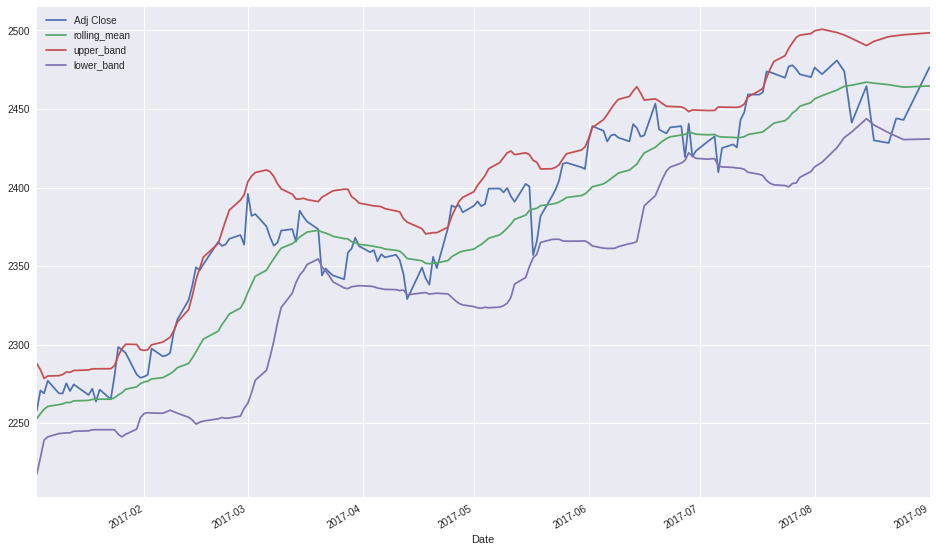

In [18]:
cols = ['Adj Close','rolling_mean', 'upper_band', 'lower_band']
df_no_headlines[cols].loc['2017-01-01':].plot(figsize=(16,10))

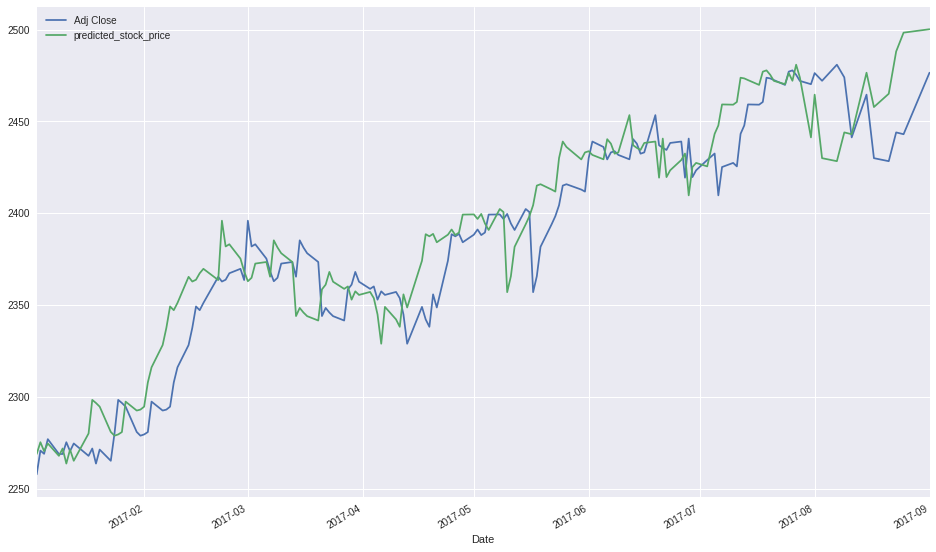

In [19]:
cols = ['Adj Close','predicted_stock_price']
df_no_headlines[cols].loc['2017-01-01':].plot(figsize=(16,10))

# The dataset of just the headlines

In [20]:
headlines_cols = ['Headlines', 'compound', 'neg', 'neu', 'pos']
df_just_headlines = data[headlines_cols]
df_just_headlines.head()

,Headlines,compound,neg,neu,pos
Date,,,,,
2007-01-03,"Ethics Changes Proposed for House Trips, K Str...",-0.9993,0.196,0.752,0.053
2007-01-04,I Feel Bad About My Face. Bush Recycles the Tr...,-0.9973,0.112,0.838,0.050
2007-01-05,Macworld Bingo. Anti-Surge Protests Against Mc...,-0.9864,0.119,0.799,0.083
2007-01-08,That R2 Unit Is a Real Bargain. HDTV Heavy. Le...,0.7383,0.070,0.857,0.073
2007-01-09,The iPhone Rumors Are Right&#8230;Finally. Pri...,-0.9961,0.102,0.862,0.036


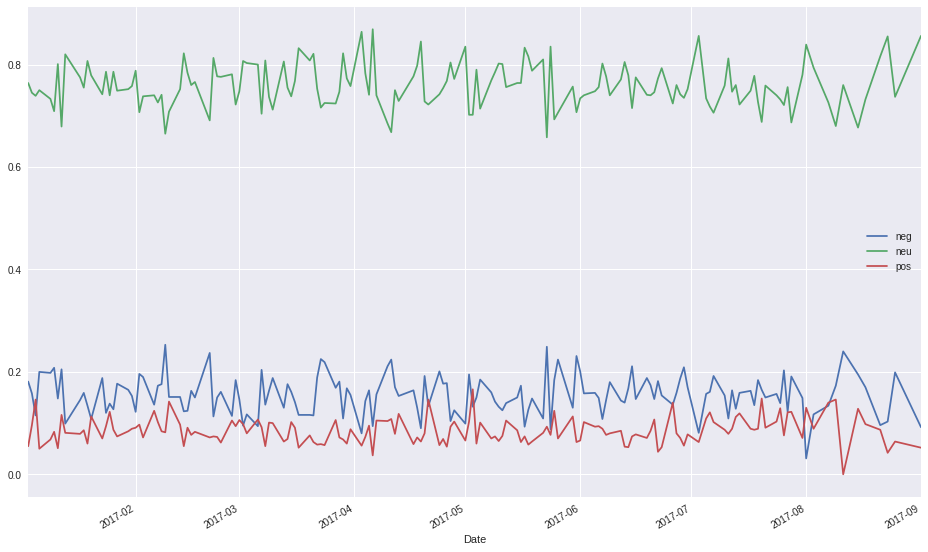

In [21]:
# normalizing the data
df_just_headlines[['neg', 'neu', 'pos']].loc['2017-01-01':].plot(figsize=(16,10))

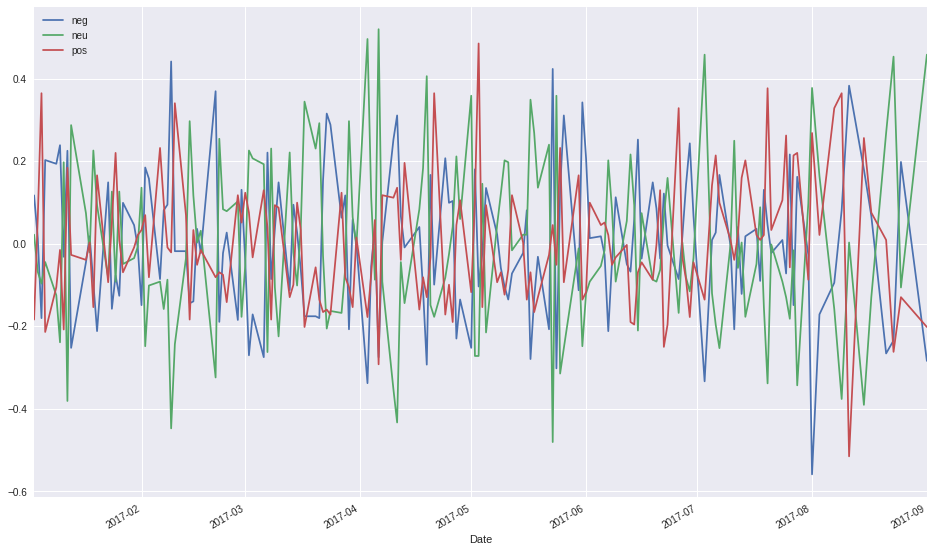

In [22]:
df = df_just_headlines[['neg', 'neu', 'pos']].loc['2017-01-01':]
df_norm = (df - df.mean()) / (df.max() - df.min())
df_norm.plot(figsize=(16,10))

# Implementation
<p> To start, we create a function to test and graph all algorithms in a loop and import all machine learning algorithms</p>

In [23]:
# Machine learning algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



def train_test_data_model(model, data, plot=False, shuffle=True, test_size = 0.2, random_state=0, labels=[], features=[], moving_average=False, name=''):
	if shuffle == True:
		X_train, X_test, y_train, y_test = train_test_split(data[features],  data[labels], test_size=test_size, random_state=random_state)
	else:
		train, test = train_test(data, ratio=test_size)
		X_test, y_test, X_train, y_train = split_train_test(train, test, labels=labels, features=features)

	print name
	print len(name) * '-'


	model.fit(X_train, y_train['predicted_stock_price'])
	prediction = model.predict(X_test)
	
	r2 = r2_score(y_test, prediction)
	mae = mean_absolute_error(y_test, prediction)

	print "R^2 score: {}".format(r2)
	print "Mean Absolute Error score: {}".format(mae)

	prediction = pd.DataFrame(prediction, index=y_test.index.values, columns=['predicted_stock'])

	test_dates_prices = y_test.copy()
	message_label = "{} Predicted Stock Prices with unshuffled data".format(name)
	title  = "{} Unshuffled Data Prediction".format(name)
    
	if shuffle == True:
		prediction.sort_index(inplace=True)
		test_dates_prices.sort_index(inplace=True)
		message_label = "{} Predicted Stock Prices".format(name)
		title  = "{} Shuffled Data Prediction".format(name)

	if moving_average == True:
		prediction['moving_average_predicted_stock'] = prediction['predicted_stock'].rolling(window=days_in_advanced,center=False).mean()

	if plot==True:
		plt.figure(figsize=(16,10))
		plt.plot(prediction['predicted_stock'].loc['2017-01-01':], label=message_label)
		if moving_average == True:
			plt.plot(prediction['moving_average_predicted_stock'].loc['2017-01-01':], label="Predicted stock price moving average")
		plt.plot(test_dates_prices.loc['2017-01-01':], label="Actual Prices")
		plt.title(title)
		plt.ylabel("Stock Prices")
		plt.xlabel("Dates 2017")
		plt.legend(loc=0)
		plt.show()

	return prediction, test_dates_prices

# First Step

### The models
<p>Here, we instantiate all the models to be used</p>

In [24]:
RFModel = RandomForestRegressor(random_state=42)
LRModel = LinearRegression()
KNNModel = KNeighborsRegressor(n_neighbors=3)
SVRModel = SVR(kernel='linear', max_iter=2000)
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)

### Dividing the features and columns that are going to be used in times series dataset
<p>First, the model selection will be done with the Time series dataset</p>

In [25]:
feature_cols = [
    'Adj Close', 
    'Volume',
    'rolling_mean',
    'upper_band',
    'lower_band'
]

label_cols = ['predicted_stock_price']

df_no_headlines.tail()

,Adj Close,predicted_stock_price,Volume,rolling_mean,upper_band,lower_band
Date,,,,,,
2017-08-17,2430.010010,2457.850098,1693.451188,2466.437012,2493.068491,2439.805532
2017-08-21,2428.370117,2465.100098,1679.163285,2465.464014,2496.081537,2434.846490
2017-08-23,2444.040039,2488.110107,1679.048005,2464.702515,2496.695373,2432.709657
2017-08-25,2443.050049,2498.370117,1671.127121,2463.898022,2497.259745,2430.536300
2017-09-01,2476.550049,2500.229980,1676.042656,2464.695020,2498.484868,2430.905171


### Setting Name and models to loop through

In [26]:
# Model names
names = ["Random Forest", "Linear Regression", "K Nearest Neighbor", "Linear Support Vector Machine", "Deep Neural Networks"]
# The instatiated models
models = [RFModel, LRModel, KNNModel, SVRModel, MLPRModel]

### Shuffled Times series dataset
<p>First we try with suffled data.</p>

Random Forest
-------------
R^2 score: -0.112948650502
Mean Absolute Error score: 128.428290455


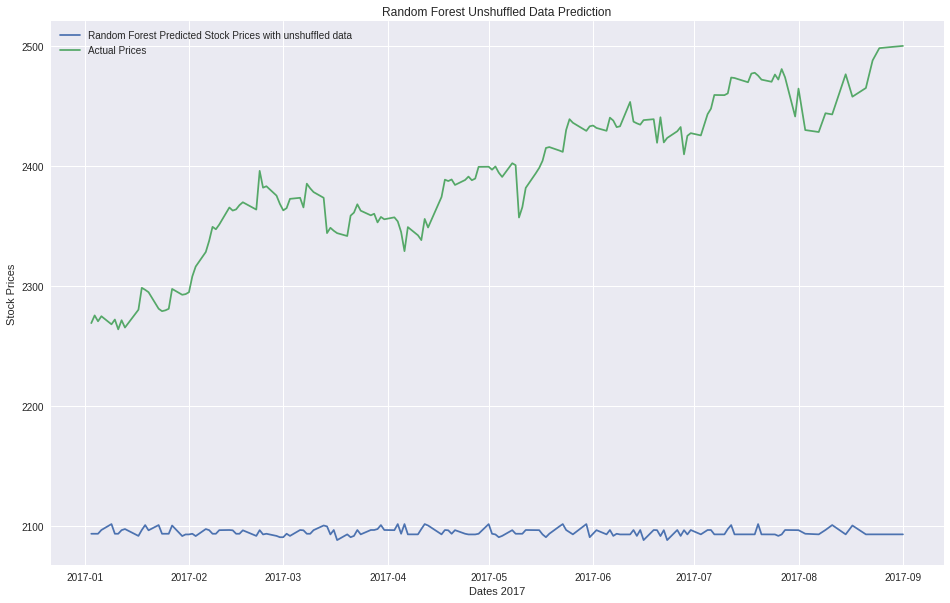

Linear Regression
-----------------
R^2 score: 0.951380096125
Mean Absolute Error score: 25.8880191215


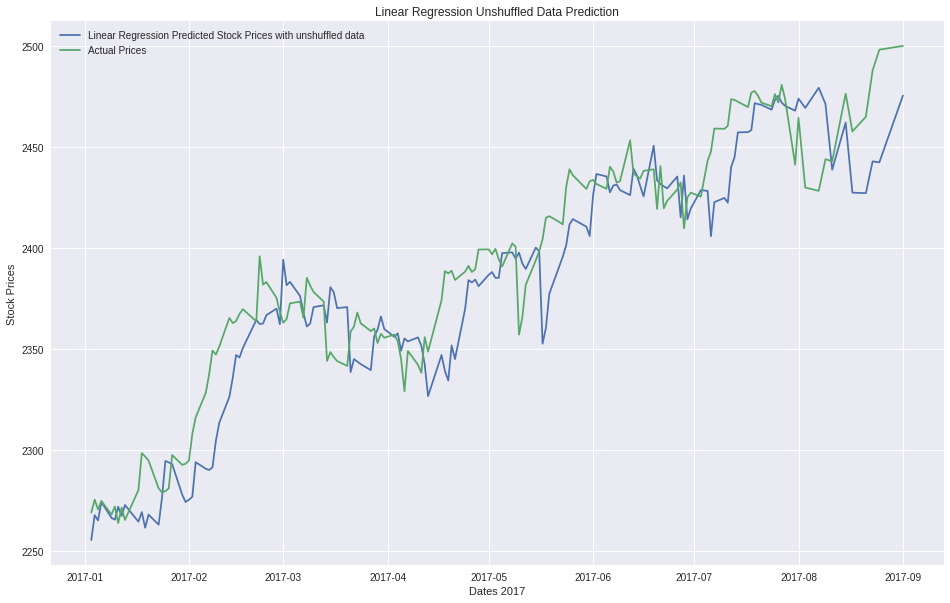

K Nearest Neighbor
------------------
R^2 score: 0.00699841510301
Mean Absolute Error score: 120.50800648


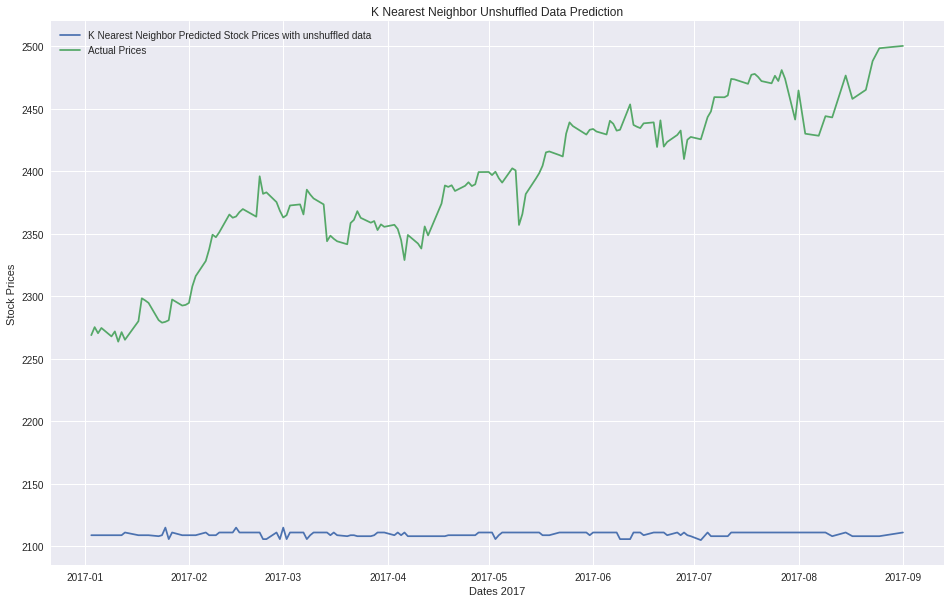

Linear Support Vector Machine
-----------------------------
R^2 score: -6.12565566319
Mean Absolute Error score: 425.958807414


/home/bwadmin/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


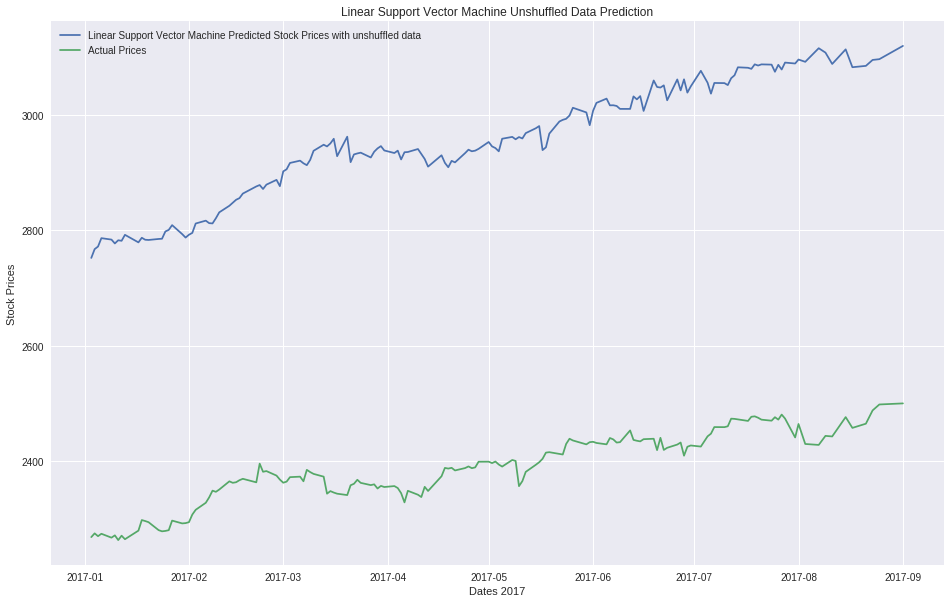

Deep Neural Networks
--------------------
R^2 score: 0.943152551133
Mean Absolute Error score: 29.1577197803


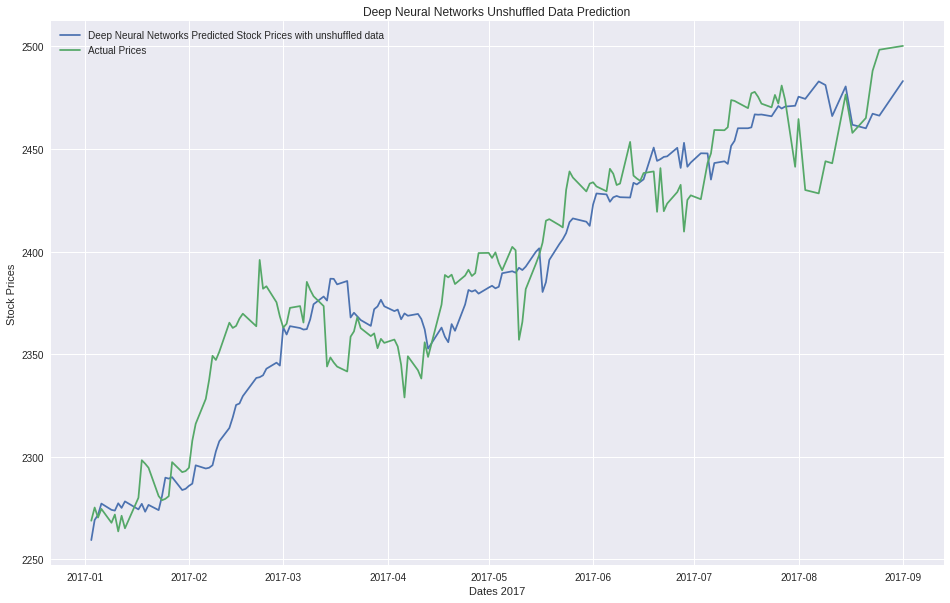

In [27]:
for model_name, prediction_model in zip(names, models):
    train_test_data_model(
        prediction_model, 
        df_no_headlines, 
        plot=True, 
        shuffle=False, 
        test_size=0.2, 
        labels=label_cols, 
        features=feature_cols, 
        moving_average=False, 
        name=model_name
    )

# Second Step

<p>Unshuffling the data seems to be affecting all the predictions negatively. In this test, however, the Linear Regression seems to outperform all the others unlike the previous test.</p>
<p>The best 2 algorithms so far are the Linear Regression algorithm and the Random Forest algorithms.</p>

## Headlines predictions
<p>In this section, the models are going to be tested against the Sentiment Analysis scores.</p>
<p>To get more accurate tests, the columns for the training and testing dataset, as the graph displayed, normalizing the data will be best.</p>

/home/bwadmin/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Headlines,compound,neg,neu,pos,Adj Close,predicted_stock_price
Date,,,,,,,
2017-08-17,Neil Gorsuch Speech at Trump Hotel Raises Ethi...,1831.951924,1800.003949,1277.469730,1649.339684,2430.010010,2457.850098
2017-08-21,All the Light Trump Was Not Supposed to See. B...,2172.051127,1302.400281,1830.450594,1551.415990,2428.370117,2465.100098
2017-08-23,"Different Day, Different Audience, and a Compl...",1845.056808,1349.470898,2087.191710,1150.819057,2444.040039,2488.110107
2017-08-25,Trump Gives Mattis Wide Discretion Over Transg...,1526.302087,1995.010792,1310.385257,1346.666446,2443.050049,2498.370117
2017-09-01,"Forceful Chief of Staff Grates on Trump, and t...",1872.600606,1275.502786,2093.774815,1239.840597,2476.550049,2500.229980


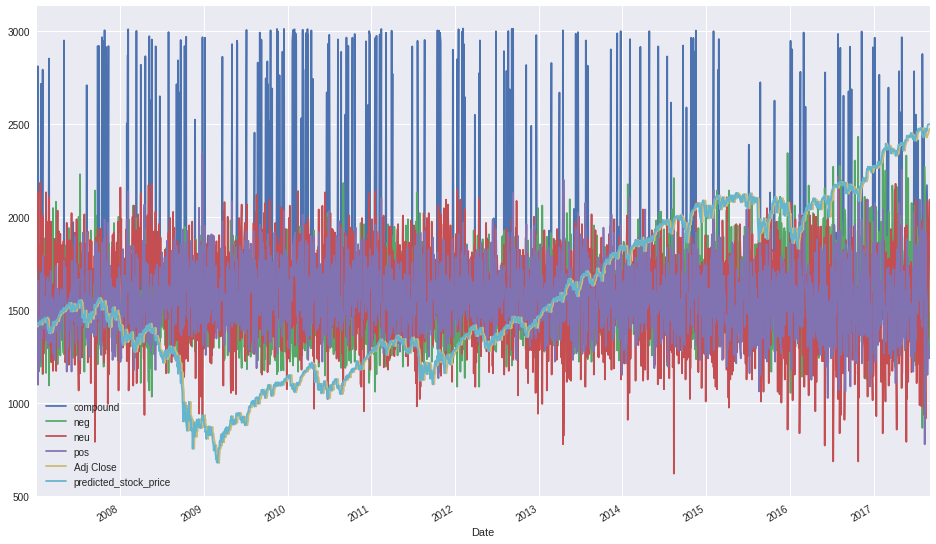

In [28]:
# Re instatiate models to avoid re training
RFModel = RandomForestRegressor(random_state=42)
LRModel = LinearRegression()
KNNModel = KNeighborsRegressor(n_neighbors=3)
SVRModel = SVR(kernel='linear', max_iter=2000)
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)

models = [RFModel, LRModel, KNNModel, SVRModel, MLPRModel]

headlines_cols = ['Headlines', 'compound', 'neg', 'neu', 'pos', 'Adj Close', 'predicted_stock_price']

# Dataset just Headlines
df_just_headlines = data[headlines_cols]


# Normalizing Sentiment Analysis scores
norm_features_cols = ['compound', 'neg', 'neu', 'pos']
norm_just_headlines = df_just_headlines[norm_features_cols].copy()
df = norm_just_headlines
df_norm_sentiment = (df - df.mean()) / (df.max() - df.min())
df_just_headlines[norm_features_cols] = df_norm_sentiment


df_just_headlines[norm_features_cols] = (df_just_headlines[norm_features_cols] * data['Adj Close'].mean())
df_just_headlines[norm_features_cols] = df_just_headlines[norm_features_cols]  + data['Adj Close'].mean()
df_just_headlines.plot(figsize=(16,10))


df_just_headlines.tail()




In [29]:
feature_cols = ['compound', 'neg', 'neu', 'pos', 'Adj Close']
label_cols = ['predicted_stock_price']

### Shuffled Headlines predictions

Random Forest
-------------
R^2 score: -0.0361110267962
Mean Absolute Error score: 119.035053356


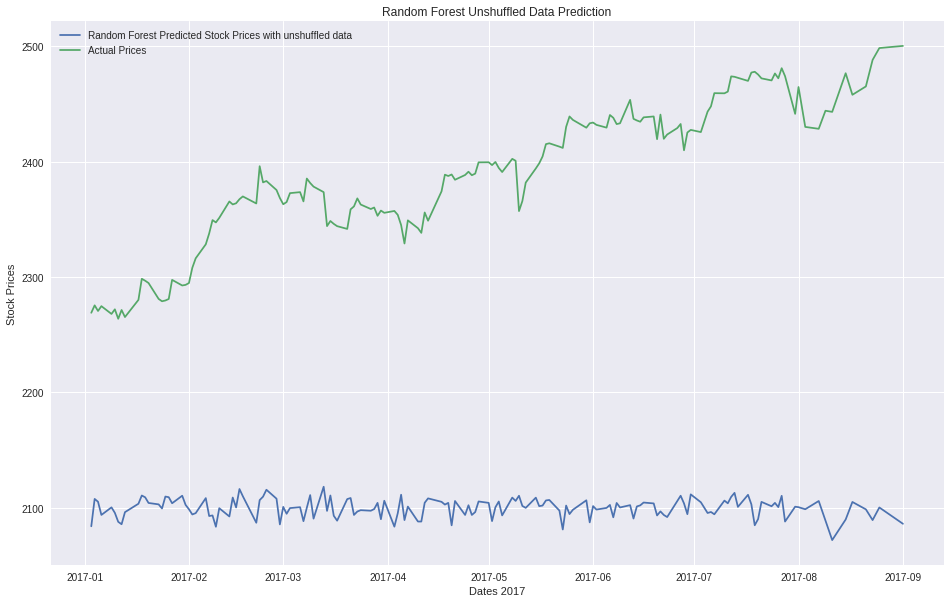

Linear Regression
-----------------
R^2 score: 0.952216047902
Mean Absolute Error score: 25.4416621102


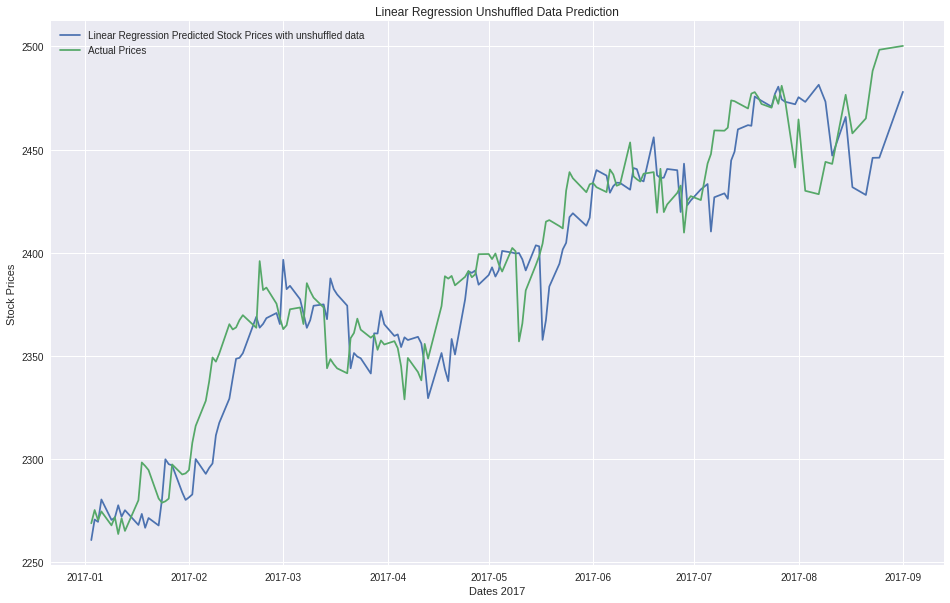

K Nearest Neighbor
------------------
R^2 score: -0.150896736385
Mean Absolute Error score: 129.387282282


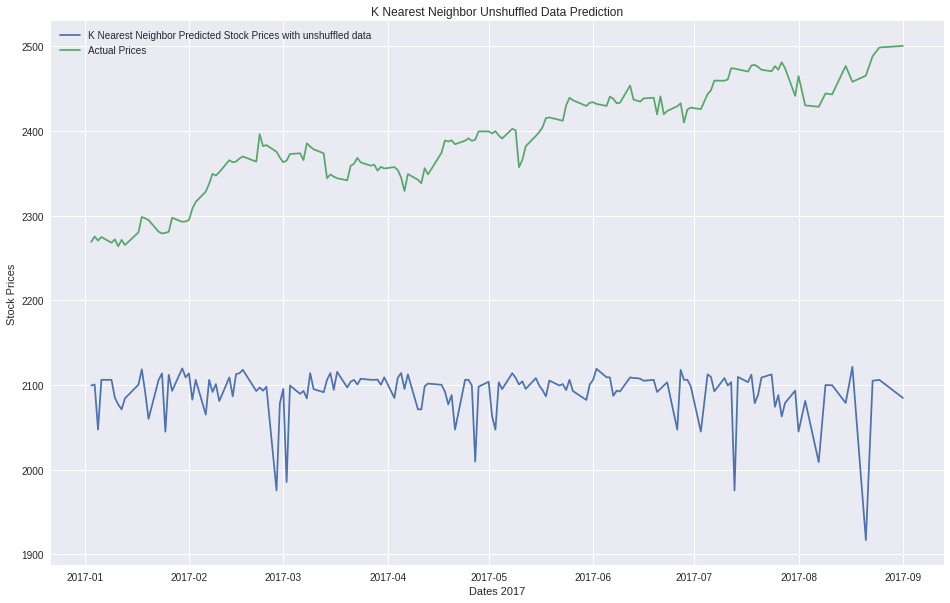

Linear Support Vector Machine
-----------------------------
R^2 score: 0.548818626671
Mean Absolute Error score: 101.167402642


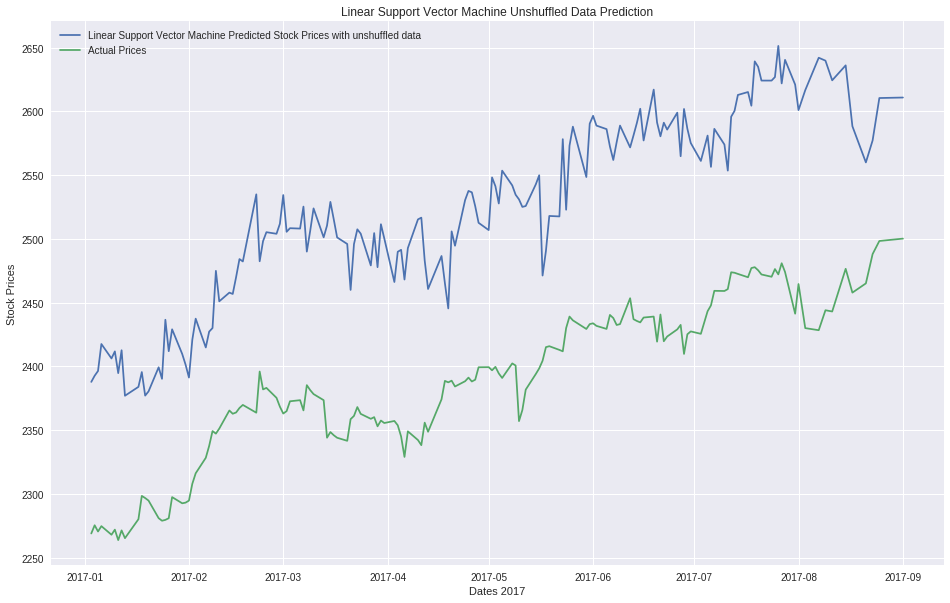

Deep Neural Networks
--------------------
R^2 score: 0.945740423151
Mean Absolute Error score: 28.603872707


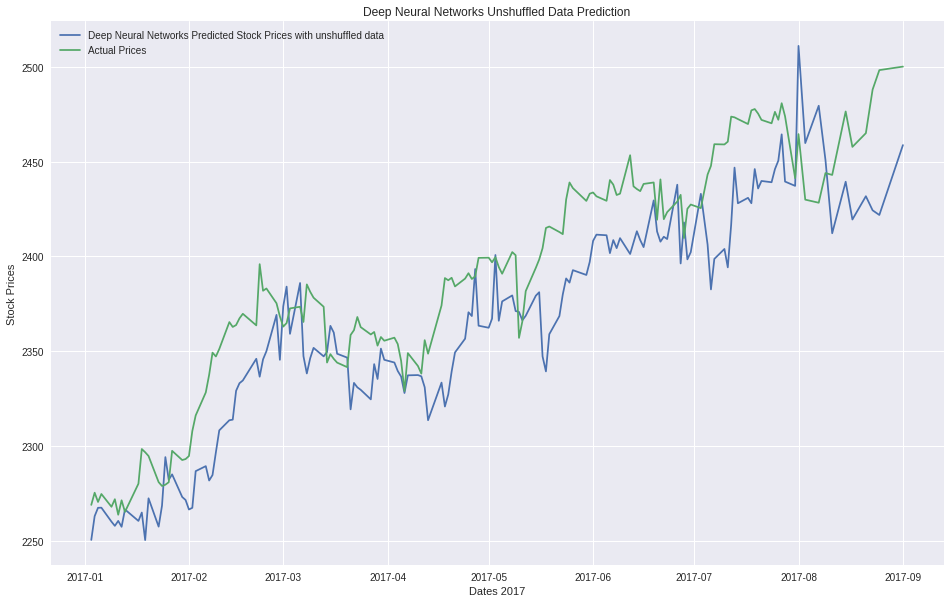

In [30]:
for model_name, prediction_model in zip(names, models):
    train_test_data_model(
        prediction_model, 
        df_just_headlines, 
        plot=True, 
        shuffle=False, 
        test_size=0.2, 
        labels=label_cols, 
        features=feature_cols, 
        moving_average=False, 
        name=model_name
    )

<p>It can be seen that the predictions for all the models are a lot better than just the timeseries. The only model that does not do well in any case is the Support Vector Machine Algorithm.</p>
<p>The improvement in the quaility and accuracy is for most models is highly notable.The KNN algorithm has now a R2 score of 16.6981476 more and a MAE score of 305.902712502 less than the test with the time series. The deep neural network alogorithm has improved exponentially as well showing a gain of 19080.980092155 and a loss of 58677 showing a huge margin of improvement.</p>

# Third Step

<p>The third step is a combination of the first 2 steps. The dataset will include both scores and the preprocessed features from the first step. </p>

,Adj Close,Volume,compound,neg,neu,pos,rolling_mean,upper_band,lower_band,predicted_stock_price
Date,,,,,,,,,,
2017-08-17,2430.010010,1693.451188,1831.951924,1800.003949,1277.469730,1649.339684,2466.437012,2493.068491,2439.805532,2457.850098
2017-08-21,2428.370117,1679.163285,2172.051127,1302.400281,1830.450594,1551.415990,2465.464014,2496.081537,2434.846490,2465.100098
2017-08-23,2444.040039,1679.048005,1845.056808,1349.470898,2087.191710,1150.819057,2464.702515,2496.695373,2432.709657,2488.110107
2017-08-25,2443.050049,1671.127121,1526.302087,1995.010792,1310.385257,1346.666446,2463.898022,2497.259745,2430.536300,2498.370117
2017-09-01,2476.550049,1676.042656,1872.600606,1275.502786,2093.774815,1239.840597,2464.695020,2498.484868,2430.905171,2500.229980


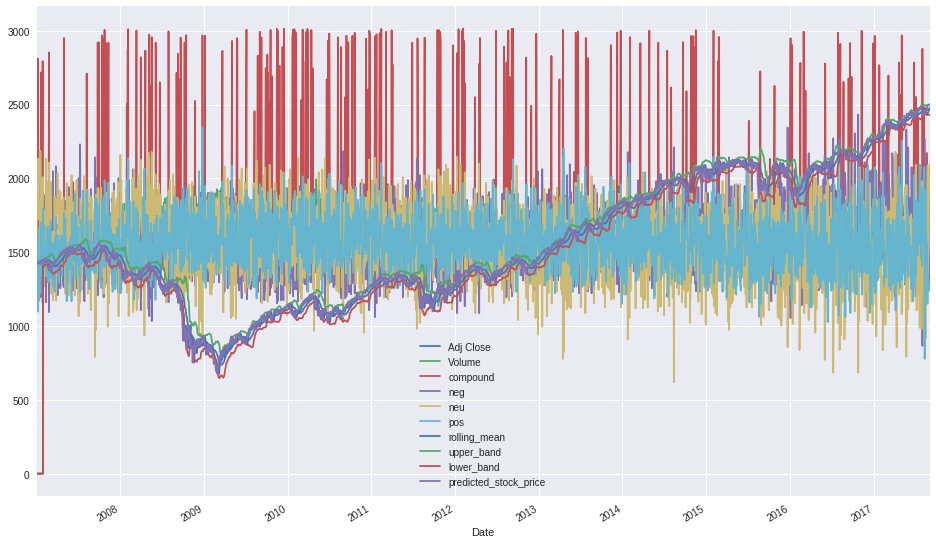

In [31]:
data['rolling_mean'] = rolling_mean
data['upper_band'] = rolling_mean + (rolling_std * no_of_std)
data['lower_band'] = rolling_mean - (rolling_std * no_of_std)
data.fillna(0, inplace=True)
data[norm_features_cols] = df_norm_sentiment
data[norm_features_cols] = data[norm_features_cols] * data['Adj Close'].mean() + data['Adj Close'].mean()


cols = [
        'Adj Close',
        'Volume',
        'compound',
        'neg',
        'neu',
        'pos',
        'rolling_mean',
        'upper_band',
        'lower_band',
        'predicted_stock_price'
]

time_series_with_headlines = data[cols]
time_series_with_headlines.plot(figsize=(16,10))
time_series_with_headlines.tail()

In [32]:
feature_cols = [
        'Adj Close',
        'Volume',
        'compound',
        'neg',
        'neu',
        'pos',
        'rolling_mean',
        'upper_band',
        'lower_band',
]
label_cols = ['predicted_stock_price']

### Time series with Headlines

Random Forest
-------------
R^2 score: -0.0673561411476
Mean Absolute Error score: 124.266217518


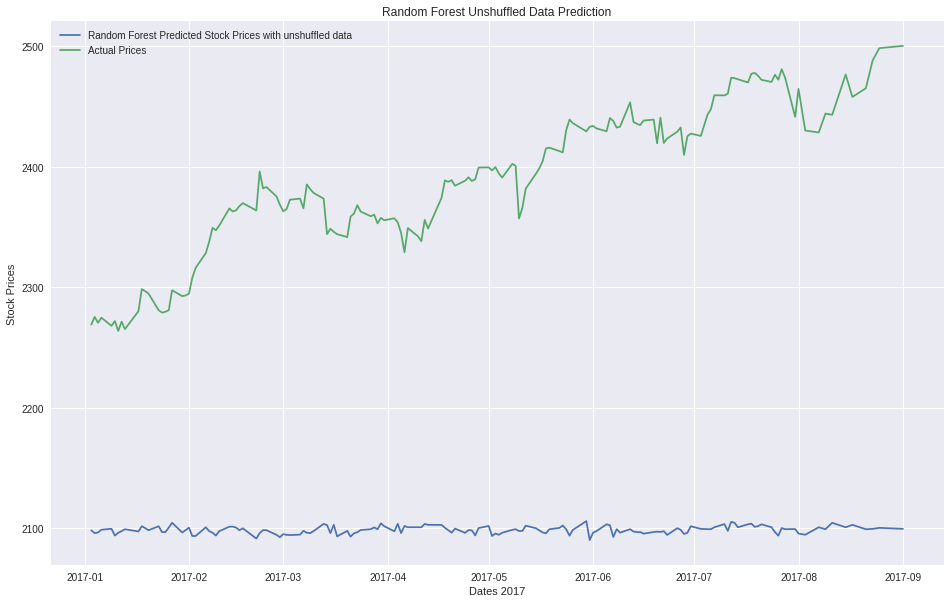

Linear Regression
-----------------
R^2 score: 0.951273521176
Mean Absolute Error score: 25.9205450499


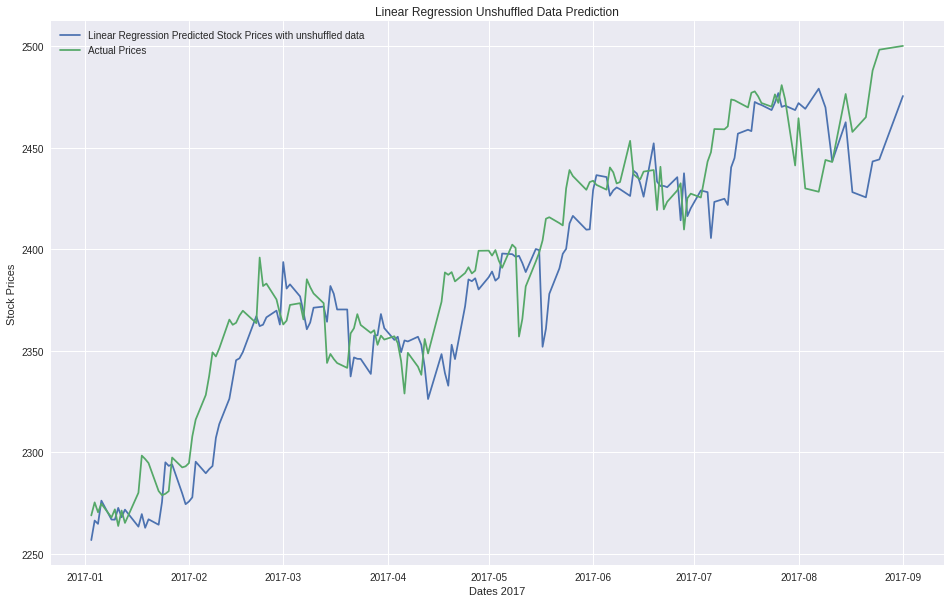

K Nearest Neighbor
------------------
R^2 score: -0.0669474547146
Mean Absolute Error score: 125.112212335


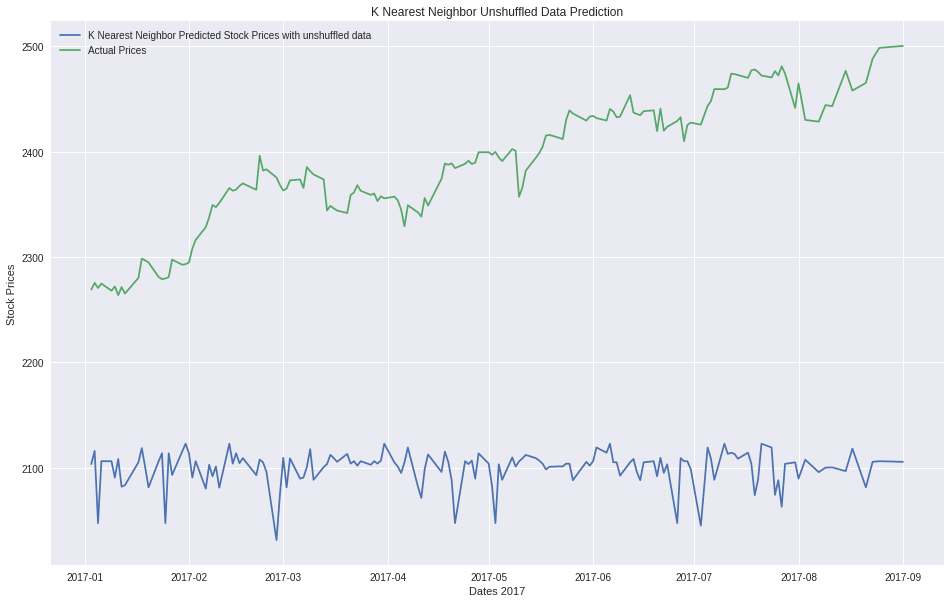

Linear Support Vector Machine
-----------------------------
R^2 score: -23.0793814774
Mean Absolute Error score: 782.953319423


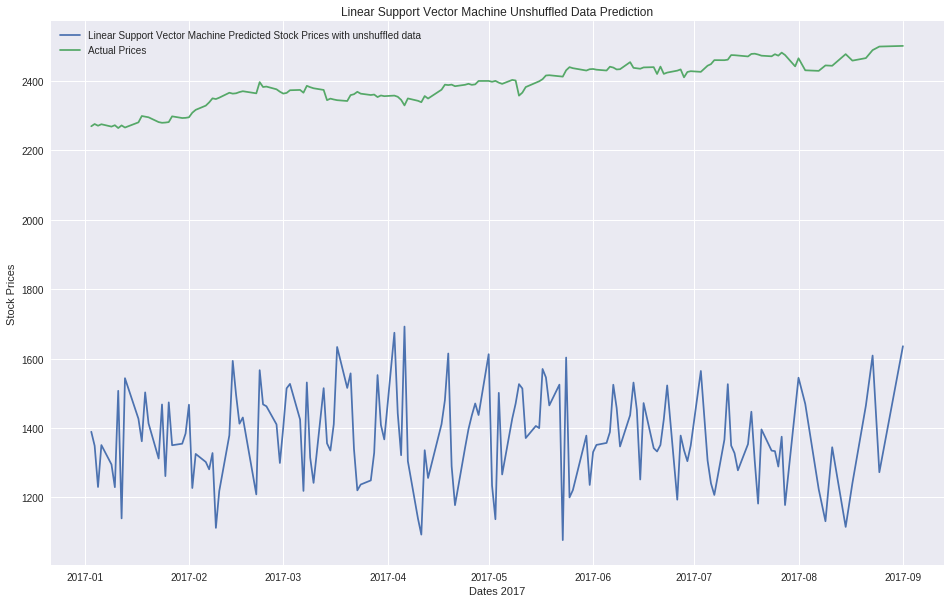

Deep Neural Networks
--------------------
R^2 score: 0.927459735027
Mean Absolute Error score: 35.0690412234


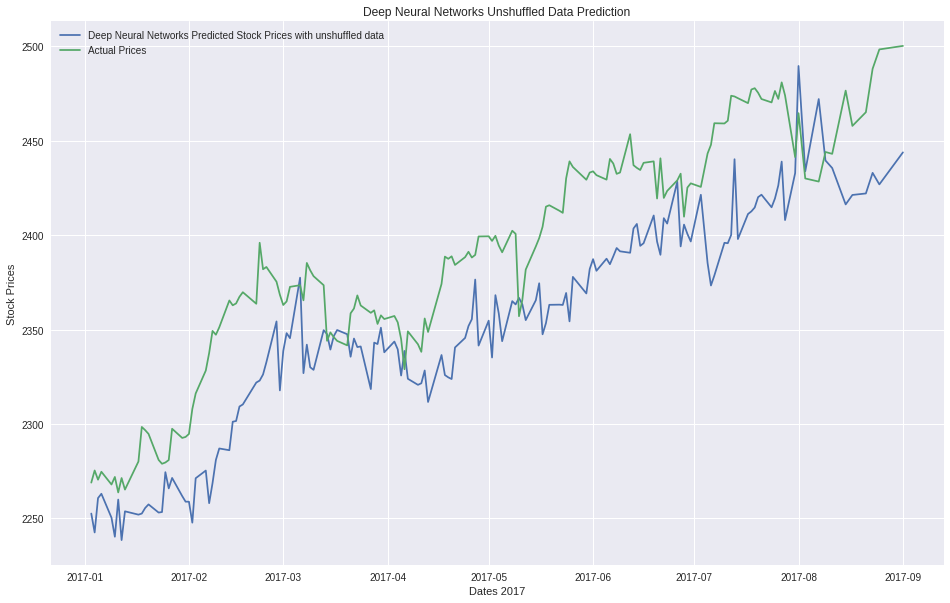

In [33]:
# Re instatiate models to avoid retraining
RFModel = RandomForestRegressor(random_state=42)
LRModel = LinearRegression()
KNNModel = KNeighborsRegressor(n_neighbors=3)
SVRModel = SVR(kernel='linear', max_iter=2000)
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)

models = [RFModel, LRModel, KNNModel, SVRModel, MLPRModel]

for model_name, prediction_model in zip(names, models):
    train_test_data_model(
        prediction_model, 
        time_series_with_headlines, 
        plot=True, 
        shuffle=False, 
        test_size=0.2, 
        labels=label_cols, 
        features=feature_cols, 
        moving_average=False, 
        name=model_name
    )

## Random Forest as chosen model
<p>Now we just compare the performance of the Random Forest Regressor on all three steps as it is the best Model so far.</p>

#### Only Time series

In [34]:
model_name = 'Deep Neural Networks'
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)
prediction_model = MLPRModel

feature_cols = [
    'Adj Close', 
    'Volume',
    'rolling_mean',
    'upper_band',
    'lower_band'
]

label_cols = ['predicted_stock_price']


prediction, test_dates_prices = train_test_data_model(
    prediction_model, 
    df_no_headlines, 
    plot=False, 
    shuffle=False, 
    test_size=0.2, 
    labels=label_cols, 
    features=feature_cols, 
    moving_average=False, 
    name=model_name
)
print "test value for 2017-08-09: ${}".format(test_dates_prices.loc['2017-08-09'].values[0])
print "predicted value for 2017-08-09: ${}".format(prediction.loc['2017-08-09'].values[0])
difference = float(prediction.loc['2017-08-09'].values[0]) - float(test_dates_prices.loc['2017-08-09'].values[0])
print "difference: ${}".format(difference)
difference_pct =   difference / float(test_dates_prices.loc['2017-08-09'].values[0]) * 100
print "difference percentage: %{:.2f}".format(difference_pct)

Deep Neural Networks
--------------------
R^2 score: 0.943152551133
Mean Absolute Error score: 29.1577197803
test value for 2017-08-09: $2444.040039
predicted value for 2017-08-09: $2481.15550766
difference: $37.1154686579
difference percentage: %1.52


#### Only Headlines Scores

In [35]:
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)
prediction_model = MLPRModel

feature_cols = ['compound', 'neg', 'neu', 'pos', 'Adj Close']
label_cols = ['predicted_stock_price']

prediction, test_dates_prices = train_test_data_model(
    prediction_model, 
    df_just_headlines, 
    plot=False, 
    shuffle=False, 
    test_size=0.2, 
    labels=label_cols, 
    features=feature_cols, 
    moving_average=False, 
    name=model_name
)
print "test value for 2017-08-09: ${}".format(test_dates_prices.loc['2017-08-09'].values[0])
print "predicted value for 2017-08-09: ${}".format(prediction.loc['2017-08-09'].values[0])
difference = float(prediction.loc['2017-08-09'].values[0]) - float(test_dates_prices.loc['2017-08-09'].values[0])
print "difference: ${}".format(difference)
difference_pct =   difference / float(test_dates_prices.loc['2017-08-09'].values[0]) * 100
print "difference percentage: %{:.2f}".format(difference_pct)

Deep Neural Networks
--------------------
R^2 score: 0.945740423151
Mean Absolute Error score: 28.603872707
test value for 2017-08-09: $2444.040039
predicted value for 2017-08-09: $2450.97408837
difference: $6.93404937167
difference percentage: %0.28


#### Time series with headlines scores

In [36]:
MLPRModel = MLPRegressor(hidden_layer_sizes=(100,200,100), activation='relu', batch_size=100, random_state=42)
prediction_model = MLPRModel

feature_cols = [
        'Adj Close',
        'Volume',
        'compound',
        'neg',
        'neu',
        'pos',
        'rolling_mean',
        'upper_band',
        'lower_band'
]
label_cols = ['predicted_stock_price']

prediction, test_dates_prices = train_test_data_model(
    prediction_model, 
    time_series_with_headlines, 
    plot=False, 
    shuffle=False, 
    test_size=0.2, 
    labels=label_cols, 
    features=feature_cols, 
    moving_average=False, 
    name=model_name
)
print "test value for 2017-08-09: ${}".format(test_dates_prices.loc['2017-08-09'].values[0])
print "predicted value for 2017-08-09: ${}".format(prediction.loc['2017-08-09'].values[0])
difference = float(prediction.loc['2017-08-09'].values[0]) - float(test_dates_prices.loc['2017-08-09'].values[0])
print "difference: ${}".format(difference)
difference_pct =   difference / float(test_dates_prices.loc['2017-08-09'].values[0]) * 100
print "difference percentage: %{:.2f}".format(difference_pct)

Deep Neural Networks
--------------------
R^2 score: 0.927459735027
Mean Absolute Error score: 35.0690412234
test value for 2017-08-09: $2444.040039
predicted value for 2017-08-09: $2439.53515434
difference: $-4.50488465816
difference percentage: %-0.18


## Refining the Deep Neural Networks as the chosen model
<p>The chosen model is the Random Forest Regressor and the dataset with best results is the preprocessed time series with no headlines scores from the first step.</p>
<p>Now it is time to choose the best hyper parameter for the Random Forest algorithm.</p>

In [56]:
feature_cols = [
    'Adj Close', 
#     'high_low_volatility_pct', 
#     'daily_pct_change', 
    'Volume',
    'rolling_mean',
    'upper_band',
    'lower_band'
]
label_cols = ['predicted_stock_price']


from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# r2 = r2_score(y_test, prediction)
# mae = mean_absolute_error(y_test, prediction)
# scoring = {'R2 score': make_scorer(r2_score), 'Mean Absolute Error': make_scorer(mean_absolute_error)}



param_grid = [{
    'hidden_layer_sizes': [(100, 200, 100), (200,500,100), (300,100)], 
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'batch_size': [100,200,50,20],
#     'solver': ['lbfgs', 'sgd', 'adam']
}]



# Instantiate Random Forest Regressor
MLPRModel = MLPRegressor(random_state=42)

#Set features and labels 
df = df_no_headlines[window_roll:].copy()

df.dropna(inplace=True)


X = df[feature_cols]
y = df[label_cols]


# # Split testing and training sets

X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=0, shuffle=False)


clf = GridSearchCV(MLPRModel, param_grid)

In [ ]:
clf.fit(X_train, y_train['predicted_stock_price'])

In [ ]:
# Get Best Parameters
clf.best_params_

In [ ]:
# Instantiate Random Forest Model with Best parameters 
RFModel = RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=42)
RFModel.fit(X_train, y_train['predicted_stock_price'])
prediction = RFModel.predict(X_test)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
print "R^2 score: {}".format(r2)
print "Mean Absolute Error score: {}".format(mae)

### Ploting the result of the refined model

In [ ]:
prediction = pd.DataFrame(prediction, index=y_test.index.values, columns=['predicted_stock'])
test_dates_prices = y_test.copy()
prediction.sort_index(inplace=True)
test_dates_prices.sort_index(inplace=True)
plt.figure(figsize=(16,10))
plt.plot(prediction['predicted_stock'].loc['2017-01-01':], label="Best model prediction")
plt.plot(test_dates_prices.loc['2017-01-01':], label="Actual Prices")
plt.title("Refined Random Forest Score")
plt.ylabel("Stock Prices")
plt.xlabel("Dates 2017")
plt.legend(loc=0)

In [ ]:
print "test value for 2017-08-09: ${}".format(test_dates_prices.loc['2017-08-09'].values[0])
print "predicted value for 2017-08-09: ${}".format(prediction.loc['2017-08-09'].values[0])
difference = float(prediction.loc['2017-08-09'].values[0]) - float(test_dates_prices.loc['2017-08-09'].values[0])
print "difference: ${}".format(difference)
difference_pct =   difference / float(test_dates_prices.loc['2017-08-09'].values[0]) * 100
print "difference percentage: %{:.2f}".format(difference_pct)

## Testing Model with Google

In [ ]:
single_ticker = 'GOOGL'
data = getMainDataset(single_ticker=single_ticker, headlines=True, current_headlines=collect_current_headlines)
data['high_low_volatility_pct'] = ((data['High'] - data['Adj Close']) / data['Adj Close']) * 100
data['daily_pct_change'] = ((data['Adj Close'] - data['Open']) / data['Open']) * 100
data['predicted_stock_price'] = data['Adj Close'].shift(-days_in_advanced)
data = data[:-days_in_advanced]
no_of_std = 2
rolling_mean = data['Adj Close'].rolling(days_in_advanced).mean()
rolling_std = data['Adj Close'].rolling(days_in_advanced).std()
data['rolling_mean'] = rolling_mean
data['upper_band'] = rolling_mean + (rolling_std * no_of_std)
data['lower_band'] = rolling_mean - (rolling_std * no_of_std)

data.fillna(0, inplace=True)
cols = [
        'Adj Close',
        'Volume',
        'compound',
        'neg',
        'neu',
        'pos',
        'high_low_volatility_pct',
        'daily_pct_change',
        'rolling_mean',
        'upper_band',
        'lower_band',
        'predicted_stock_price'
]


google_df = data[cols]
google_df.tail()

In [ ]:
feature_cols = [
    'Adj Close', 
    'high_low_volatility_pct', 
    'daily_pct_change', 
    'Volume',
    'rolling_mean',
    'upper_band',
    'lower_band'
]
label_cols = ['predicted_stock_price']

df = google_df
X = df[feature_cols]
y = df[label_cols]

# Split testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=0)


RFModel = RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=42)
RFModel.fit(X_train, y_train['predicted_stock_price'])
prediction = RFModel.predict(X_test)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
print "R^2 score: {}".format(r2)
print "Mean Absolute Error score: {}".format(mae)

prediction = pd.DataFrame(prediction, index=y_test.index.values, columns=['predicted_stock'])
test_dates_prices = y_test.copy()
prediction.sort_index(inplace=True)
test_dates_prices.sort_index(inplace=True)


print "test value for 2017-08-09: ${}".format(test_dates_prices.loc['2017-08-09'].values[0])
print "predicted value for 2017-08-09: ${}".format(prediction.loc['2017-08-09'].values[0])
difference = float(prediction.loc['2017-08-09'].values[0]) - float(test_dates_prices.loc['2017-08-09'].values[0])
print "difference: ${}".format(difference)
difference_pct =   difference / float(test_dates_prices.loc['2017-08-09'].values[0]) * 100
print "difference percentage: %{:.2f}".format(difference_pct)

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(prediction['predicted_stock'].loc['2017-01-01':], label="Best model prediction")
plt.plot(test_dates_prices.loc['2017-01-01':], label="Actual Prices")
plt.title("Refined Random Forest Score")
plt.ylabel("Stock Prices")
plt.xlabel("Dates 2017")
plt.legend(loc=0)